<a href="https://colab.research.google.com/github/benjamin-du/all_things_trees/blob/main/1.%20Understand_how_trees_work_visually_the_split_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")


     |████████████████████████████████| 61kB 3.2MB/s 


In [ ]:
from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from functools import partial

# Understanding Trees...

<p style="font-family: Georgia">Trees form the basis of many modern machine-learning algorithms.  Yet many people don't really know how they work. 
This usually results in one of the following hard-times for the data-scientist:

- They will have trouble answering specific questions during screening technical tests (such as the ones they give you on CodingGames)
- They'll stumble on their words when explaining the algorithm during technical interviews
- Even after making it inside the company, they will lose the attention of the stakeholders while they talk about obscure metrics like ROC-AUC, when they could have instead used what I call "minimal scenarii" to explain their models in a very easy manner.

This series of articles aims at helping you <b>develop a strong intuition</b> about what kind of decisions your algorithm will make and why. We'll also see along the way <b>what you don't want to do</b> when you use tree-based algorithms. 
To help you gain these intuitions, we'll learn how to code a tree, of course, but most importantly we will walk through a lot of visualizations and minimal-case scenarii.</p>


PLEASE NOTE: you'll see very simple plots of IRIS datasets and such in the first posts. If you are an advanced reader, please don't dismiss the entire series on this fact. The latter posts will build on these simple examples to analyze far more complex situations :)

# Understanding trees, visually

## The ideal case: a feature that makes a perfect split

We start by loading the iris dataset. It contains data about flowers. We'd like to know if we can predict the "specie" of the flower given its characteristics:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
iris_df = sns.load_dataset("iris")

iris_df.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,species
77,6.7,3.0,5.0,1.7,versicolor
144,6.7,3.3,5.7,2.5,virginica
89,5.5,2.5,4.0,1.3,versicolor


First, let's plot some histograms. How many flowers have a petal_lenght < 2.5 ? What specie are they all coming from ?

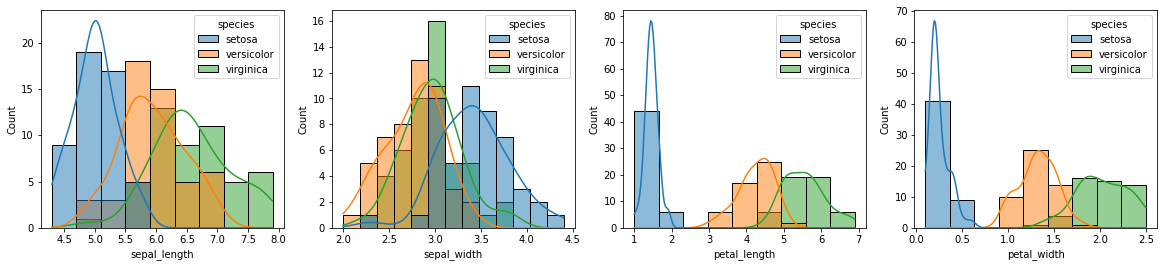

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(20,4))
for i, column in enumerate(iris_df.columns.tolist()[:-1]):
    sns.histplot(x=column, data=iris_df, hue="species", kde=True, ax=axes[i])

You got it: a characteristic (a "feature") will help us decide whether a particular flower is a setosa or not 100% of the time. It is the size of its petal (width or length will do). Of course, a decision tree is capable of figuring that out:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


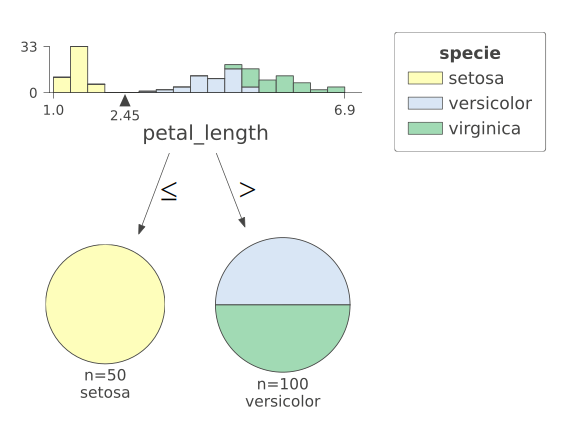

In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

def make_classification_and_plot_tree(X_train, y_train, max_depth=1, min_samples_leaf=1):
    labels = y_train.unique().tolist()
    y_train = y_train.map({"setosa": 0, "versicolor":1, "virginica":2, "Edelweiss":3})

    # (note that I ask for a tree with a max_depth of one.
    # So it finds the best split it can do on all the data and stops there)
    clas = tree.DecisionTreeClassifier(max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf)  
    clas.fit(X_train.values, y_train)

    viz = dtreeviz(clas,
                   X_train,
                   y_train,
                   target_name='specie',
                   feature_names=X_train.columns.tolist(),
                   class_names=labels, 
                   histtype= 'barstacked',
                   scale=2.3)

    return viz

viz = make_classification_and_plot_tree(X_train, y_train)
viz

We are entering the mechanics of the tree now !
If you run the above cell multiple times, you will see that either petal_length or petal_width is chosen. That's because splitting on one or the other doesn't affect the result at all (Look at the histograms above to convince yourself of that).

<br />



In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

def compute_and_print_feature_importance(X_train, y_train, max_depth=1, min_samples_leaf=1, criterion=None):
    feat_imp = []
    for i in range(200):
        if not criterion:
            criterion = np.random.choice(["gini", "entropy"])
        clas = tree.DecisionTreeClassifier(max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                        criterion=criterion)
        clas.fit(X_train.values, y_train)
        feat_imp.append(clas.tree_.compute_feature_importances())

    return pd.DataFrame([np.array(feat_imp).sum(axis=0)], columns=X_train.columns.tolist())


compute_and_print_feature_importance(X_train, y_train)

,sepal_length,sepal_width,petal_length,petal_width
0,0.0,0.0,102.0,98.0


As you can see, the tree chooses either variable half of the time. If we wanted petal_length to be selected all the time as first split, we would need to find a way to make the split with petal_width less perfect:

## Minimal Scenario II: What happens if we don't have an ideal split ?



To do that, we could create a row that contains a "versicolor" specie, and make it so that this flower has the petal_witdh of a "setosa"

In [ ]:
# Let's pick a versicolor: 
subset = iris_df[ iris_df['species'] == "versicolor"].copy()
print("Min petal_width for a versicolor:", subset['petal_width'].min())
# Let's find the mean value for petal_width for a setosa
setosas = iris_df[ iris_df['species'] == "setosa"].copy()
print("Max petal_width for a setosa:", setosas['petal_width'].mean() )
random_versicolor = subset.sample(1)
random_versicolor['petal_width'] = setosas['petal_width'].mean()  # affect a "setosa" kind of width
print("random_versicolor:  \n", random_versicolor)

Min petal_width for a versicolor: 1.0
Max petal_width for a setosa: 0.2459999999999999
random_versicolor:  
     sepal_length  sepal_width  petal_length  petal_width     species
96           5.7          2.9           4.2        0.246  versicolor


In [ ]:
iris_df = iris_df.append(random_versicolor)
iris_df.tail(3)

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.300,virginica
149,5.9,3.0,5.1,1.800,virginica
96,5.7,2.9,4.2,0.246,versicolor


Petal_width is not a perfect separator anymore (see that little bump on the left of the graph ?):

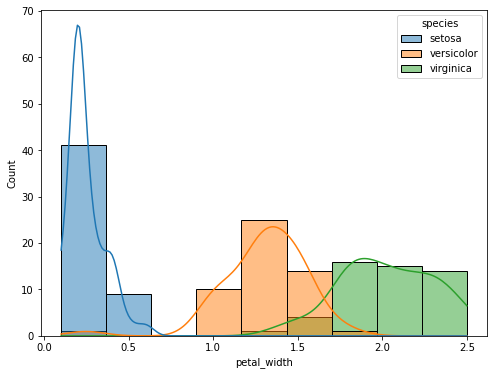

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(x="petal_width", data=iris_df, hue="species", kde=True)

As a result, the feature petal_width won't be selected as first split anymore:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


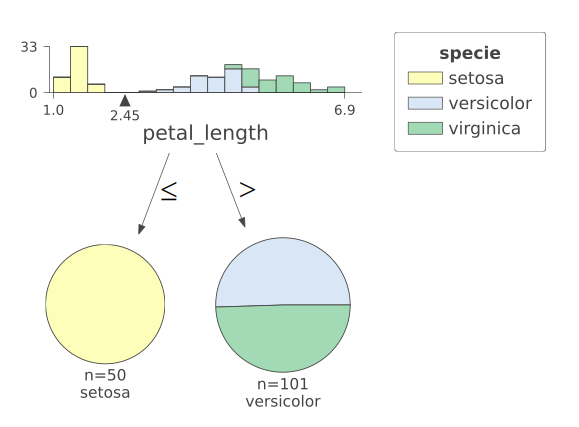

In [ ]:
X_train = iris_df.iloc[:, :4]
y_train = iris_df['species']

make_classification_and_plot_tree(X_train, y_train)

You can run the above cell how many times you would like, petal_width is not going to be selected as first split anymore. To gain even more intuition, let's remove the feature "petal_length" (now our best predictor) and plot again the graph:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


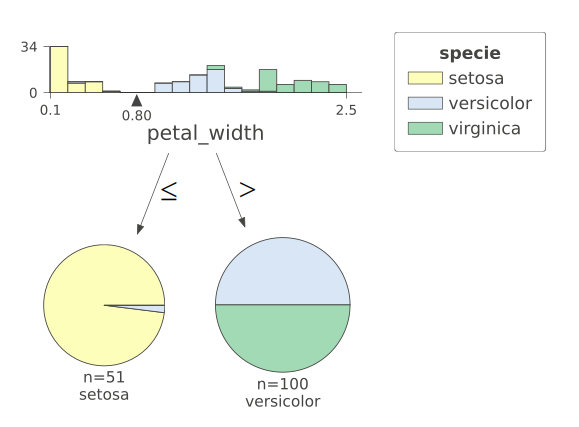

In [ ]:
X_train = iris_df[['sepal_length', 'sepal_width', 'petal_width']]
y_train = iris_df['species']

make_classification_and_plot_tree(X_train, y_train)

As you can see, now that is doesn't have access to the best predictor variable, the tree falls back on the second best. Of course, this now gives us a split that is not perfect ! 

But what would happen if we had a variable that also made a perfect split, but with a smaller node. Would it be picked ? 


## Minimal-case scenario III: small perfect split vs. big imperfect split

For our purposes, I'll add a fourth category of flowers. The Edelweiss. This plant is very specific: it has a petal width of 3.5cm all the time. It is also very rare: you have to climb all the mountain to get one. So we only have four of them in our dataset:

In [ ]:
edelweisses_df = iris_df.copy()
edelweisses_df['stem'] = np.random.rand(151) * 2
edelweisses_flowers = iris_df[ iris_df['species'] == "virginica"].sample(4).copy()
edelweisses_flowers['stem'] = 3.5
edelweisses_flowers['species'] = "Edelweiss"
edelweisses_df = edelweisses_df.append(edelweisses_flowers)
edelweisses_df = edelweisses_df[["sepal_length", "sepal_width", "petal_length", "petal_width", "stem", "species"]]
edelweisses_df.tail(7)

,sepal_length,sepal_width,petal_length,petal_width,stem,species
148,6.2,3.4,5.4,2.300,1.895038,virginica
149,5.9,3.0,5.1,1.800,0.708975,virginica
96,5.7,2.9,4.2,0.246,0.113386,versicolor
133,6.3,2.8,5.1,1.500,3.500000,Edelweiss
140,6.7,3.1,5.6,2.400,3.500000,Edelweiss
129,7.2,3.0,5.8,1.600,3.500000,Edelweiss
104,6.5,3.0,5.8,2.200,3.500000,Edelweiss


As you can see on graphs 3 and 5, we know have two features that, if we split on them, will give us a perfect node on the left. Petal_length, and stem:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


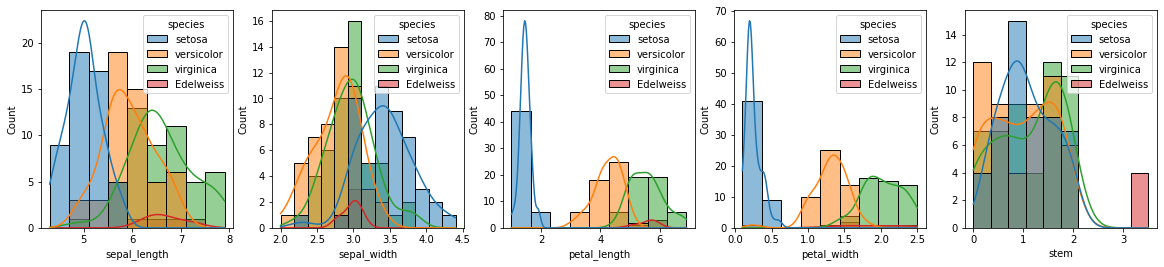

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20,4))
for i, column in enumerate(edelweisses_df.columns.tolist()[:-1]):
    sns.histplot(x=column, data=edelweisses_df, hue="species", kde=True, ax=axes[i])

Let's use the tree's "feature importance" to see how many times each feature is used to make the first split in 200 experiments:

In [ ]:
X_train = edelweisses_df.iloc[:, :5]
y_train = edelweisses_df['species']

compute_and_print_feature_importance(X_train, y_train)

,sepal_length,sepal_width,petal_length,petal_width,stem
0,0.0,0.0,200.0,0.0,0.0


So far so good. Given two variables that give a perfect node, you'd like your algorithm to pick the one that classifies the most examples at once. 

BUT !

What if your tree has the choice between a small perfect Node and a big imperfect one ?

Let's remove petal_length. The Tree has now the choice between stem and petal_width:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


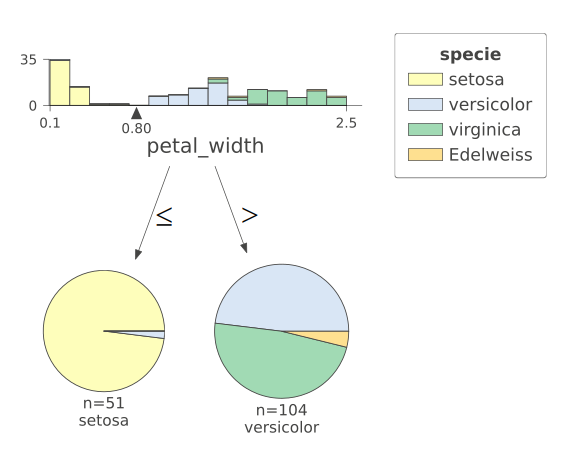

,sepal_length,sepal_width,petal_width,stem
0,0.0,0.0,200.0,0.0


In [ ]:
X_train = edelweisses_df.drop(["petal_length", "species"], axis=1)
y_train = edelweisses_df['species']

viz = make_classification_and_plot_tree(X_train, y_train, max_depth=1)
viz
compute_and_print_feature_importance(X_train, y_train)

It does <b> NOT </b> pick "stem", ever. Even though it would give us a nice perfect bubble on the left.

# Conclusions

Using graphs and minimal-case scenarii, we've come to understand the following:

- A decision tree wants to make splits that optimally separates the data
- When given the choice between two splits that result in equivalent separation, if chooses randomly between the two
- If two variables provide an opportunity to create a perfect Node, the Tree will pick the one that classifies more examples
- If one variable offers a perfect split, but only for a few instances, the Tree might prefer another variable that result in less pure Nodes, but help classify more observations...

<b> This is important ! </b>
<br />
Because of this, your variables that actually contain a small signal (but with true predictive power) can be drawn by other variables that contain only noise. We will see concrete exemples of how this happens in future posts and what you can do about it, so stay tuned! 


In the meantime, we have one question left. When would the algorithm decide that our perfect little bubble obtained by splitting on the "stem" feature is worth more than the rest ? 
<br />
To answer that, we'll need to introduce you to the actual formula the Decision Tree uses to make its choices.


---


We'll do just that in the next notebook ;)

In [ ]:
# Add Edelweises until split done on that